In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [34]:
IMG_SIZE = 224
BATCH_SIZE = 32
IMG_SHOW_NUM = 6
EPOCHS = 10
LEARNING_RATE = 0.001

In [4]:
transformer = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

testTransformer = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [5]:
trainData = datasets.ImageFolder(root='../lab1/train_test_sw/train_sw', transform=transformer)
testSet = datasets.ImageFolder(root='../lab1/train_test_sw/test_sw', transform=testTransformer)

trainSet, valSet = torch.utils.data.random_split(trainData, [int(0.8 * len(trainData)), len(trainData) - int(0.8 * len(trainData))])

In [6]:
trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valSet, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=True)

print('Train: ', len(trainSet))
print('Validation: ', len(valSet))
print('Test: ', len(testSet))

Train:  821
Validation:  206
Test:  259


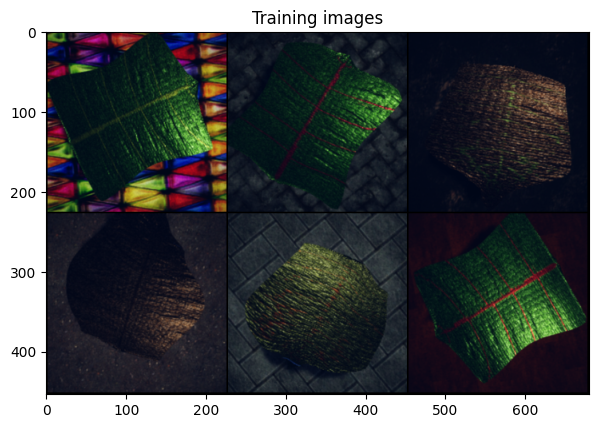

In [7]:
def show_images(imgs, title):
    grid = utils.make_grid(imgs, nrow = 3, padding = 2, normalize=True)
    plt.figure(figsize = (7, 10))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(title)

dataiter = iter(trainLoader)
images, labels = next(dataiter)
show_images(images[:IMG_SHOW_NUM], title = "Training images")

In [8]:
def plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val):
    
    _ , axes = plt.subplots(1, 2, figsize=(12, 8))
    ax1, ax2 = axes
    
    ax1.plot(losses_train, label='Training Loss')
    ax1.plot(losses_val, label='Validation Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
        
    ax2.plot(accuracies_train, label='Training Accuracy')
    ax2.plot(accuracies_val, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracies')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()

# Convolutional Neural Network

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128*26*26, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 128*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [35]:
model = Model()

criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses_train = []
losses_val = []
accuracies_train = []
accuracies_val = []

for epoch in range(EPOCHS): 
    print()
    print(f'EPOCH {epoch+1}') 
    print()

    model.train(True)

    running_loss, last_loss, avg_loss = 0., 0., 0.
    train_correct, train_total = 0, 0
    
    for i, data in enumerate(trainLoader):
        inputs, labels = data

        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss += loss.item()

        if i % 10 == 0:
            last_loss = running_loss / 5
            print(f'Batch {i} Loss train: {last_loss:.3f}')
            running_loss = 0.
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_loss /= int(len(trainSet)/BATCH_SIZE)
    
    running_vloss = 0.
    
    model.eval()

    val_correct, val_total = 0, 0

    with torch.no_grad():
        for i, vdata in enumerate(valLoader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss.item()

            _, vpredicted = torch.max(voutputs.data, 1)
            val_total += vlabels.size(0)
            val_correct += (vpredicted == vlabels).sum().item()

    avg_vloss = running_vloss / (i + 1)

    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    losses_train.append(avg_loss)
    losses_val.append(avg_vloss)
    accuracies_train.append(train_accuracy)
    accuracies_val.append(val_accuracy)

    print(f'Loss train {avg_loss:.3f}, loss valid {avg_vloss:.3f}')
    print(f'Accuracy train {train_accuracy:.2%}, accuracy valid {val_accuracy:.2%}')


EPOCH 1

Batch 0 Loss train: 0.318
Batch 10 Loss train: 5.398
Batch 20 Loss train: 2.965
Loss train 2.049, loss valid 1.511
Accuracy train 26.43%, accuracy valid 25.73%

EPOCH 2

Batch 0 Loss train: 0.295
Batch 10 Loss train: 2.595
Batch 20 Loss train: 2.048
Loss train 1.184, loss valid 0.862
Accuracy train 52.86%, accuracy valid 62.14%

EPOCH 3

Batch 0 Loss train: 0.159
Batch 10 Loss train: 1.566
Batch 20 Loss train: 1.521
Loss train 0.783, loss valid 0.665
Accuracy train 70.40%, accuracy valid 74.27%

EPOCH 4

Batch 0 Loss train: 0.122
Batch 10 Loss train: 1.122
Batch 20 Loss train: 1.021
Loss train 0.565, loss valid 0.684
Accuracy train 78.20%, accuracy valid 66.50%

EPOCH 5

Batch 0 Loss train: 0.104
Batch 10 Loss train: 0.929
Batch 20 Loss train: 0.917
Loss train 0.529, loss valid 1.021
Accuracy train 78.93%, accuracy valid 59.71%

EPOCH 6

Batch 0 Loss train: 0.156
Batch 10 Loss train: 1.214
Batch 20 Loss train: 0.960
Loss train 0.552, loss valid 0.515
Accuracy train 78.20%, ac

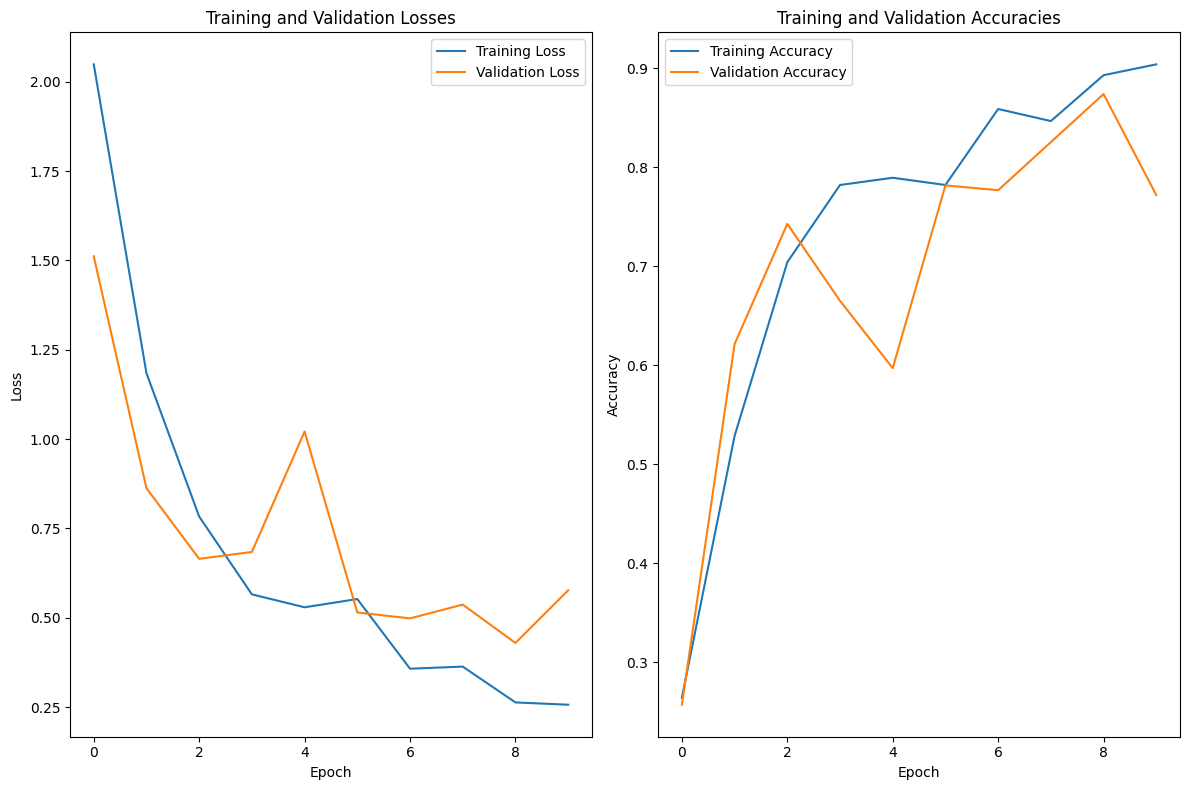

In [36]:
plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val)

In [37]:
model.eval()

test_correct, test_total = 0, 0

with torch.no_grad():
    for i, tdata in enumerate(testLoader):
        tinputs, tlabels = tdata
        toutputs = model(tinputs)
        _, tpredicted = torch.max(toutputs.data, 1)
        test_total += tlabels.size(0)
        test_correct += (tpredicted == tlabels).sum().item()

test_accuracy = test_correct / test_total

print(f'Test accuracy: {test_accuracy:.2%}')

Test accuracy: 77.22%


# Wnioski i prównanie z SSN

Jak widizmy nawet prosta konwolucyjna sieć neuronowa, trenowana na tylko 10 epoch radzi sobie o wiele lepiej niż SSN:

 * CNN - train accuracy - 90,38%, val accuracy - 77,18%, test accuracy = 77,22%
 * SNN - train accuracy - 99,51%, val accuracy 59,22%, test accuracy 67,18% 

Przy czym CNN trenował na tylko 10 epoch, a SNN na 200.
Czat trenowania dla CNN to 8min 11s na CPU, na GPU byłoby to o wiele szybsze, dla SNN ten czas wyniósł 3min 54s.
Learning rate dla CNN to 0.001, a dla SNN 0.1.
Funcka aktywacji dla CNN to ReLU, dla SNN Tanh.

Podsumowując CNN znacznie lepiej radzi sobie w kwestii rozponawania zdjęć, nawet najprostsza nie zoptymalizowana sieć outperformuje SNN, przy czym nie dochodzi tutaj do overfittingu tak jak w przypadku SNN.